[*********************100%%**********************]  1 of 1 completed

Epoch 1/10



C:\Users\hanss\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0698 - val_loss: 0.0203
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0427 - val_loss: 0.0496
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0384 - val_loss: 0.0306
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0346 - val_loss: 0.0417
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0362 - val_loss: 0.0386
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0349 - val_loss: 0.0358
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0334 - val_loss: 0.0383
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0354 - val_loss: 0.0566
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0330 - val_loss: 0.0267
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0292 - val_loss: 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━

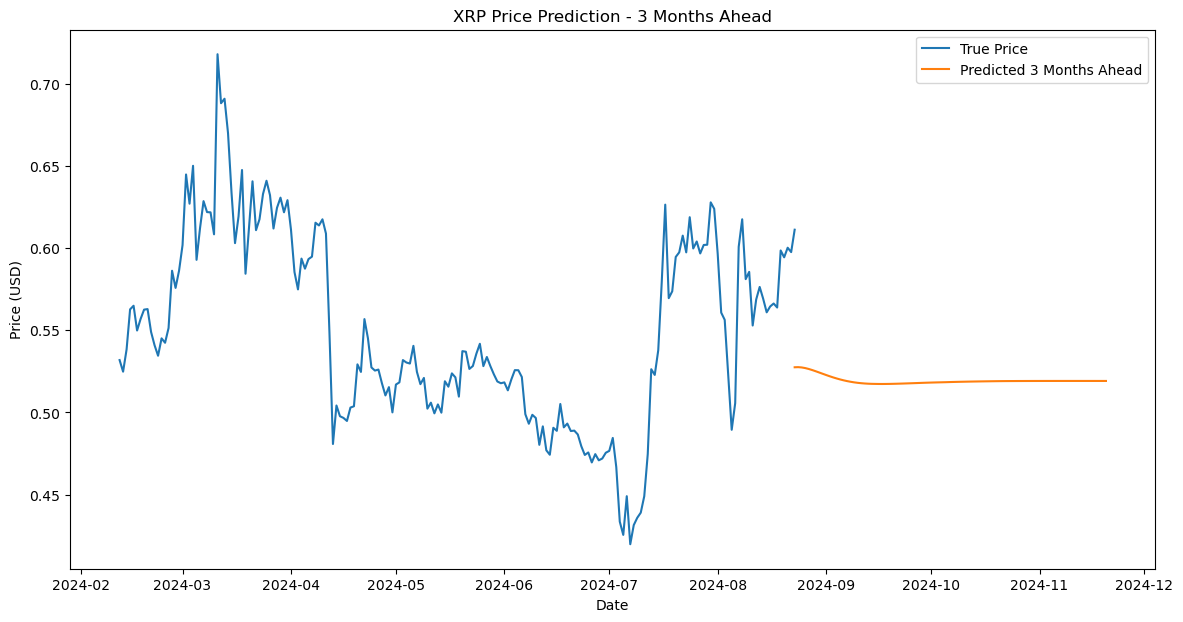

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch historical data
ticker_symbol = "XRP-USD"
xrp_data = yf.download(ticker_symbol, start="2022-01-01", end="2024-08-24")

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(xrp_data['Close'].values.reshape(-1, 1))

# Prepare Training and Testing Datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create a dataset with 60 timesteps and 1 output for training
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 90):  # 90 timesteps ahead
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step + 90, 0])  # Predict 90 days ahead
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predict 3 months ahead (iterative prediction)
def predict_future(model, data, time_step=60, days_to_predict=90):
    temp_input = data[-time_step:].tolist()
    future_predictions = []

    for _ in range(days_to_predict):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]

        input_data = np.array(temp_input).reshape(1, -1, 1)
        pred = model.predict(input_data)
        temp_input.append(pred[0, 0])
        future_predictions.append(pred[0, 0])

    return future_predictions

# Predict the next 90 days
predicted_future = predict_future(model, test_data.flatten(), time_step=60, days_to_predict=90)
predicted_future = scaler.inverse_transform(np.array(predicted_future).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(xrp_data.index[-len(test_data):], scaler.inverse_transform(test_data), label="True Price")
plt.plot(pd.date_range(start=xrp_data.index[-1], periods=90), predicted_future, label="Predicted 3 Months Ahead")
plt.title('XRP Price Prediction - 3 Months Ahead')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
